  Cloning https://github.com/facebookresearch/segment-anything-2.git to /tmp/pip-req-build-pxdm42vl
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything-2.git /tmp/pip-req-build-pxdm42vl
  Resolved https://github.com/facebookresearch/segment-anything-2.git to commit 2b90b9f5ceec907a1c18123530e92e794ad901a4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 5.6 MB/s eta 0:00:00
  Created wheel for SAM-2: filename=sam_2-1.0-cp310-cp310-linux_x86_64.whl size=525486 sha256=1ae9e8bdccee0d303860bde2e0e81637e473d23b1d43a8f6df48edcd9c2a1708
  Stored in directory: /tmp/pip-ephem-wheel-cache-9tazqpx9/wheels/e9/c8/6c/4c2a92da6da05eba099a6984ad38f50a0ab4677158c913432d
  Created wheel 

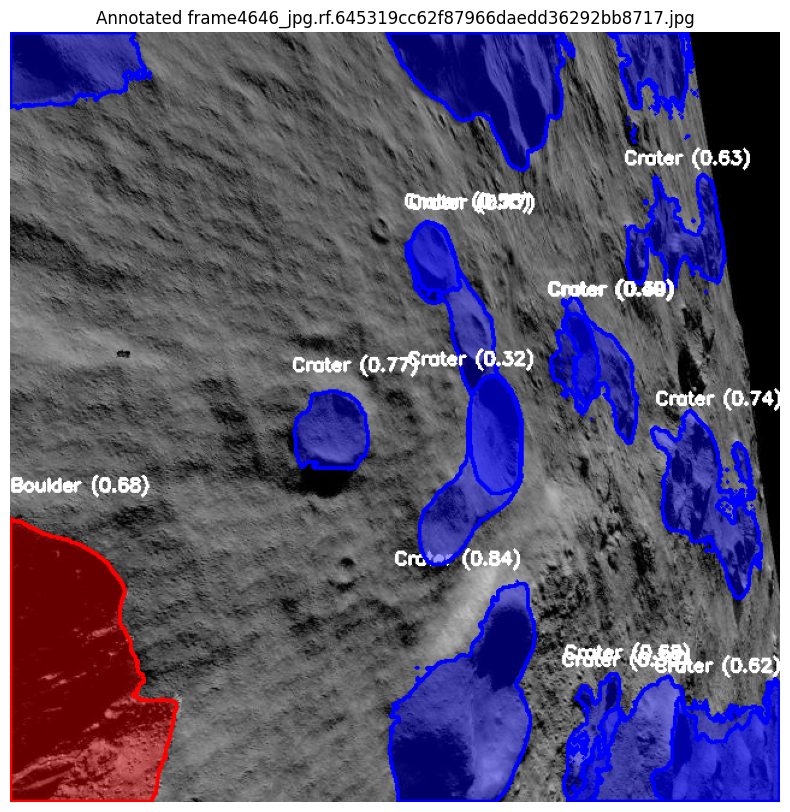

In [1]:
# Install required packages
!pip install git+https://github.com/facebookresearch/segment-anything-2.git
!pip install torch torchvision opencv-python numpy ultralytics  # Added ultralytics for YOLO

# Download SAM 2 checkpoint (if not already present)
!wget -O /kaggle/working/sam2_hiera_large.pt https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt

# Import libraries
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from ultralytics import YOLO
import torch
import cv2
import os
import numpy as np

# Define paths for directory and outputs
image_dir = "/kaggle/input/dataset-1"  # Directory containing your images
yolo_model_path = "/kaggle/input/weights/best.pt"  
output_annotated_dir = "/kaggle/working/annotated_images"  # Where to save annotated images
os.makedirs(output_annotated_dir, exist_ok=True)

# Step 1: Load YOLO model
yolo_model = YOLO(yolo_model_path)

# Step 2: Load SAM 2 model
checkpoint = "/kaggle/working/sam2_hiera_large.pt"
model_cfg = "sam2_hiera_l"
sam2_model = build_sam2(model_cfg, checkpoint, device="cuda")
predictor = SAM2ImagePredictor(sam2_model)

# Step 3: Process each image in the directory
for img_name in os.listdir(image_dir):
    if not img_name.endswith((".jpg", ".jpeg", ".png")):  # Check for image extensions
        continue
    
    img_path = os.path.join(image_dir, img_name)
    image = cv2.imread(img_path)
    if image is None:
        print(f"Image {img_name} not found, skipping.")
        continue
    
    # Run YOLO prediction
    results = yolo_model.predict(img_path, save=False, conf=0.25)
    
    # Extract bounding boxes with confidence scores
    boxes = []
    for result in results:
        for box in result.boxes:
            x_min, y_min, x_max, y_max = box.xyxy[0].tolist()  # Bounding box coordinates
            class_id = int(box.cls[0])  # Class ID
            confidence = float(box.conf[0])  # Confidence score
            if class_id in [0, 1]:  # Only boulders (0) and craters (1)
                boxes.append([x_min, y_min, x_max, y_max, class_id, confidence])
    
    if not boxes:
        print(f"No boulders or craters detected in {img_name}.")
        continue
    else:
        print(f"Detected {len(boxes)} boulders/craters in {img_name}.")
    
    # Segment and annotate
    predictor.set_image(image)
    annotated_image = image.copy()
    
    for box in boxes:
        x_min, y_min, x_max, y_max, class_id, confidence = box
        input_box = torch.tensor([[x_min, y_min, x_max, y_max]], device="cuda")
        
        # Generate masks
        masks, scores, logits = predictor.predict(
            box=input_box,
            multimask_output=False
        )
        
        mask = masks[0]  # Single mask output
        label = "Boulder" if class_id == 0 else "Crater"
        color = (0, 0, 255) if class_id == 0 else (255, 0, 0)  # Blue for Boulder, Red for Crater
        
        # Ensure mask is 2D and convert to uint8
        if mask.ndim == 3:
            mask = mask[0]
        mask = mask.astype(np.uint8) * 255
        
        # Find contours and annotate
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if not contours:
            continue
        
        # Apply mask overlay
        overlay = annotated_image.copy()
        cv2.fillPoly(overlay, contours, color)
        alpha = 0.4
        cv2.addWeighted(overlay, alpha, annotated_image, 1 - alpha, 0, annotated_image)
        cv2.drawContours(annotated_image, contours, -1, color, 2)
        
        # Add label with confidence
        x, y = int(x_min), int(y_min)
        text = f"{label} ({confidence:.2f})"
        cv2.putText(annotated_image, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
    
    # Save the annotated image
    output_path = os.path.join(output_annotated_dir, f"{img_name.split('.')[0]}_annotated.jpg")
    cv2.imwrite(output_path, annotated_image)
    print(f"Annotated image saved to {output_path}")

print(f"Segmentation and annotation complete. Annotated images saved in {output_annotated_dir}")

# Optional: Visualize the last processed image
if boxes:  # Only visualize if there was at least one detection
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
    plt.title(f"Annotated {img_name}")
    plt.axis("off")
    plt.show()

In [3]:
import shutil

source_dir = "/kaggle/working/annotated_images"
zip_path = "/kaggle/working/annotated_images"

shutil.make_archive(zip_path, 'zip', source_dir)

print("Zipping complete. You can now download the file.")


Zipping complete. You can now download the file.
